### Imports

In [29]:
import numpy as np
import pandas as pd

# optional 'chdir' (if not installed via 'pip' -> ModuleNotFoundError)
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
import os
module_path = './gym_anytrading'
if not os.path.exists(module_path):
    os.chdir('../')
# ------------------------------------------------------------

import gymnasium as gym
import gym_anytrading
import quantstats as qs

from stable_baselines3 import A2C
import matplotlib.pyplot as plt

### Create Env

In [30]:
df = gym_anytrading.datasets.STOCKS_GOOGL.copy()

window_size = 10
start_index = window_size
end_index = start_index + len(df)

env_name = "stocks-v0"

env = gym.make(
    env_name,
    df = df,
    window_size = window_size,
    frame_bound = (start_index, end_index)
)

print ('observation_space:', env.observation_space)

observation_space: Box(-10000000000.0, 10000000000.0, (10, 2), float64)


/opt/homebrew/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (10, 2)
  logger.warn(


### Train Env

In [31]:
import random
import torch

#reproduce training and test
seed = 42
obs = env.reset(seed=seed)
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

model = A2C('MlpPolicy', env, verbose=0)

model.learn(total_timesteps=1_000)

### Test Env

In [32]:
vec_env = model.get_env()
action_stats = {0:0, 1:0}
total_reward = 0

obs = vec_env.reset()

max_range = len(df) - 12 # max. range for env.render_all()

for i in range (max_range):

    action, _states = model.predict(obs)
    action_stats[action[0]] += 1

    obs, reward, done, info = vec_env.step(action)
    total_reward += reward

print("action_stats:", action_stats)
print("total_reward:", total_reward)

vec_env.close()

action_stats: {0: 1235, 1: 1088}
total_reward: [653.3338]


### Plot Results

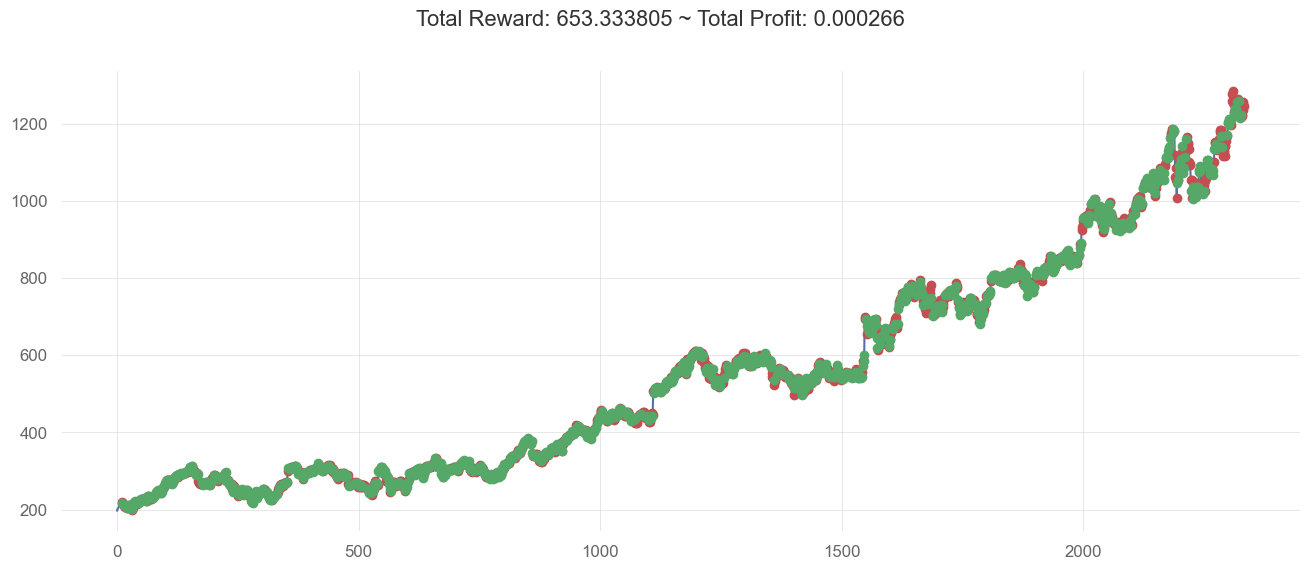

In [33]:
plt.figure(figsize=(16, 6))
env.render_all()
plt.show()

### Analysis Using `quantstats`

                           Strategy
-------------------------  ----------
Start Period               2009-05-26
End Period                 2018-08-29
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          542.13%
CAGR﹪                     22.23%

Sharpe                     0.96
Prob. Sharpe Ratio         99.86%
Smart Sharpe               0.93
Sortino                    1.46
Smart Sortino              1.42
Sortino/√2                 1.03
Smart Sortino/√2           1.0
Omega                      1.19

Max Drawdown               -30.42%
Longest DD Days            505
Volatility (ann.)          23.82%
Calmar                     0.73
Skew                       0.91
Kurtosis                   14.47

Expected Daily %           0.08%
Expected Monthly %         1.67%
Expected Yearly %          20.44%
Kelly Criterion            8.57%
Risk of Ruin               0.0%
Daily Value-at-Risk        -2.38%
Expected Shortfall (cVaR)  -2.38%

Max Consecutive Wins    

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2010-01-05,2010-07-06,2010-11-08,307,-30.423615,-29.006783
2,2011-01-19,2011-06-24,2011-12-27,342,-25.757079,-24.240576
3,2014-02-27,2015-01-12,2015-07-17,505,-18.607579,-17.469531
4,2012-01-05,2012-06-14,2012-08-14,222,-16.344947,-16.039684
5,2012-10-05,2012-11-16,2013-02-01,119,-15.737261,-15.726845


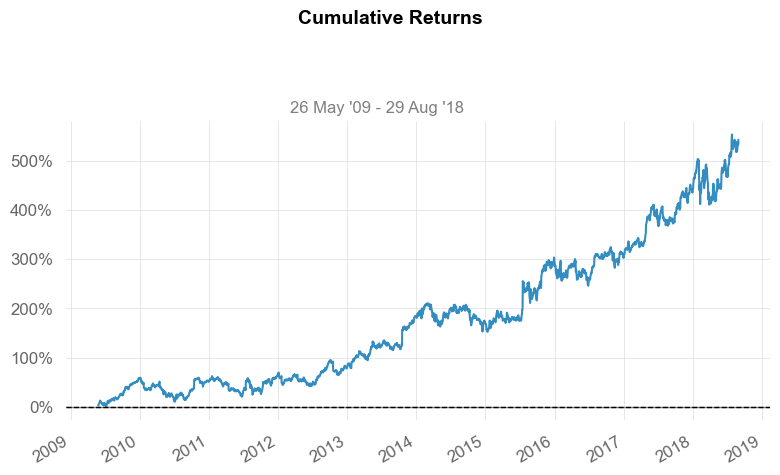

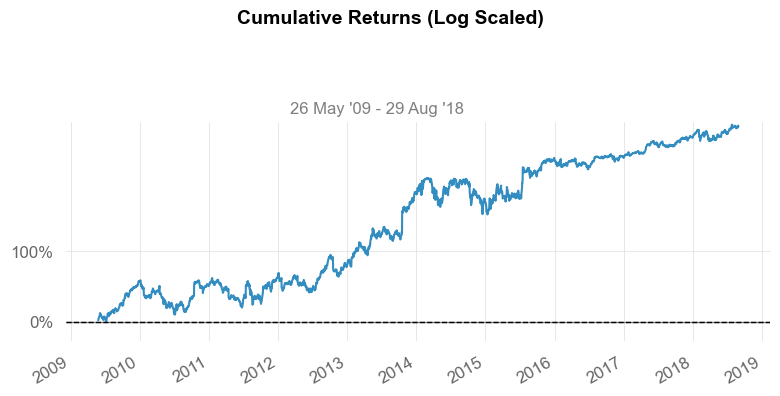

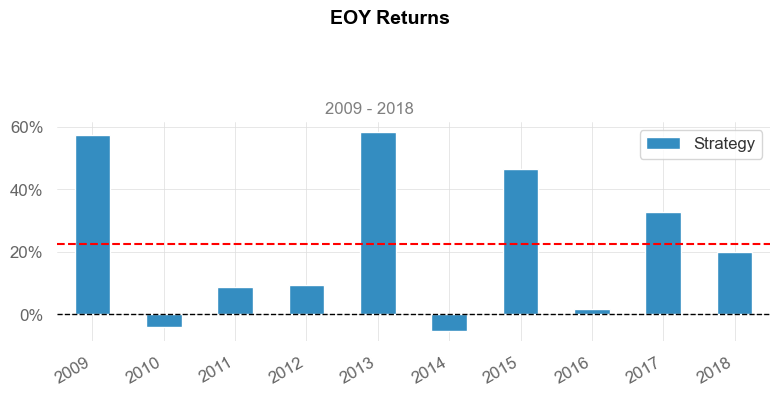

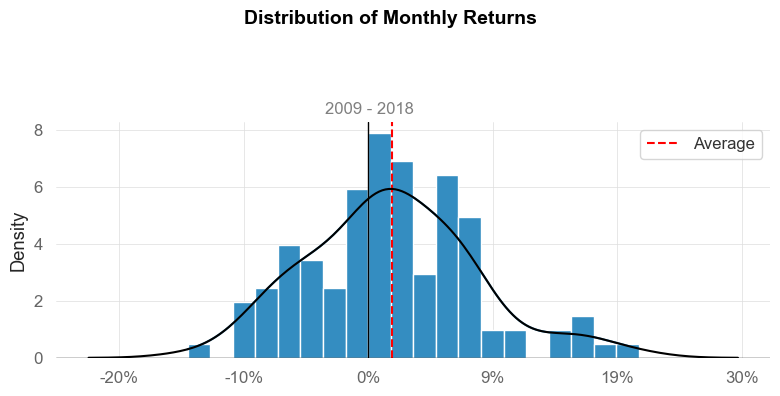

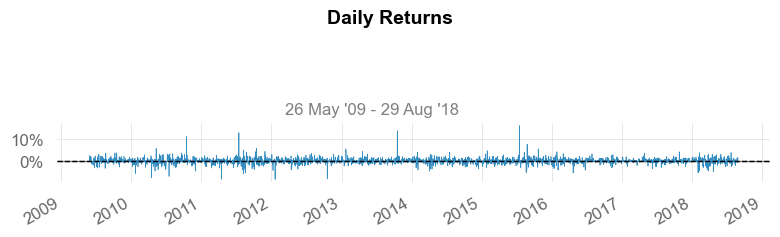

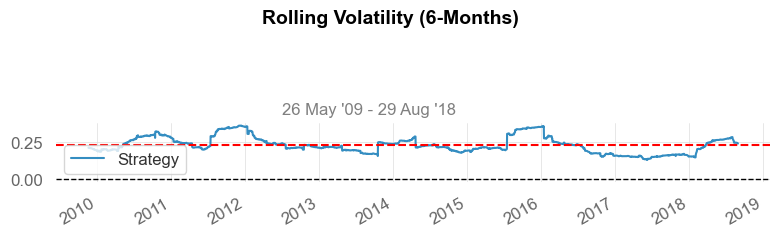

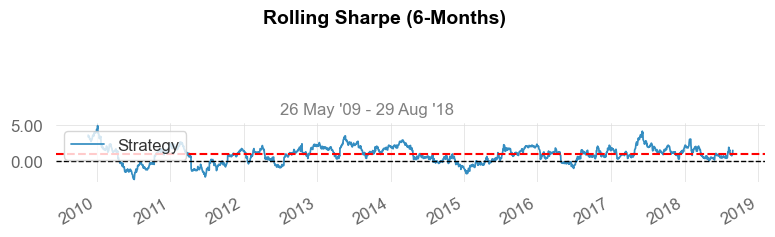

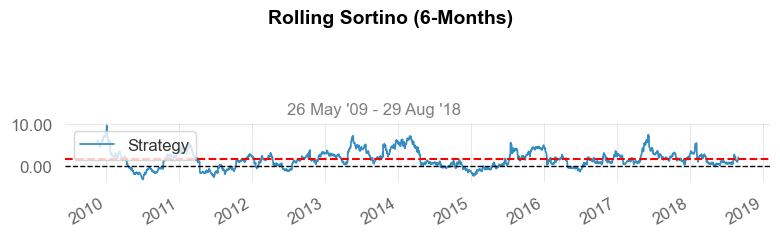

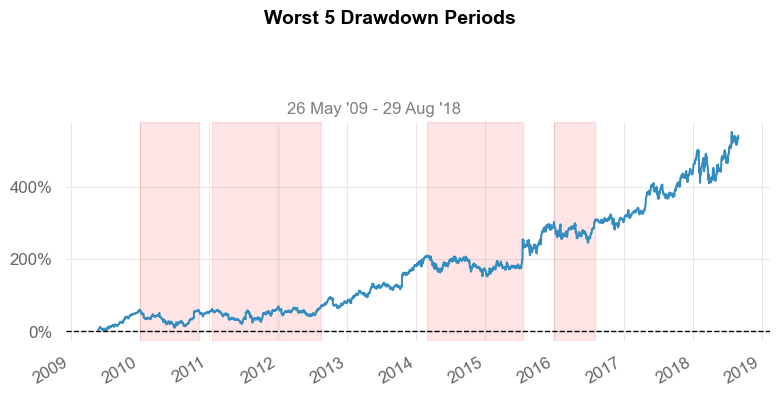

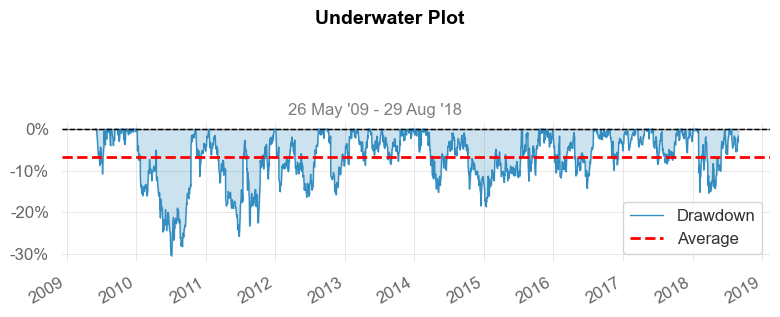

/opt/homebrew/lib/python3.11/site-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


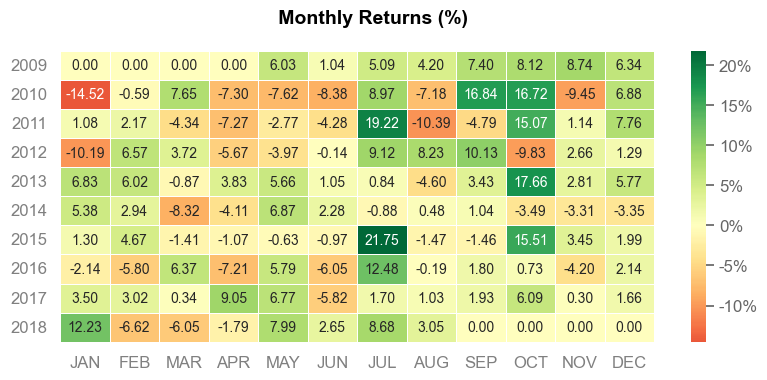

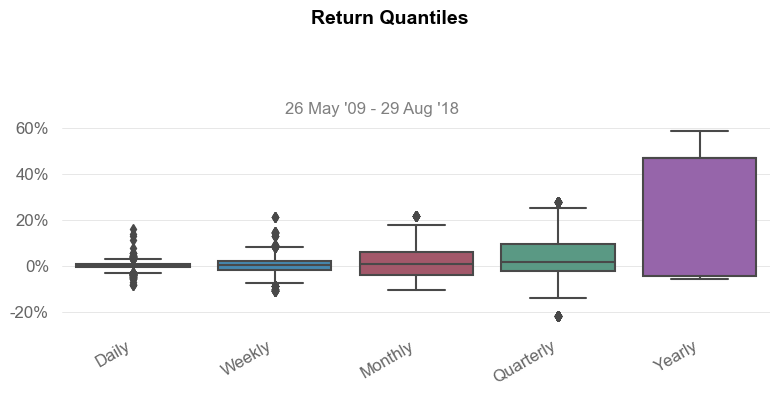

/opt/homebrew/lib/python3.11/site-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


In [34]:
qs.extend_pandas()

data = df.loc[:, 'Close']
idx = df.index

net_worth = pd.Series(data, index=idx)
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)
qs.reports.html(returns, output='SB3_quantstats.html', download_filename = 'a2c_quantstats.html')
